Enter a stock symbol to retrieve data from: AAPL
Retrieving Stock Data from introduced symbol...
[*********************100%***********************]  1 of 1 completed
Forecasting stock DataFrame...
Plotting existing and forecasted values...


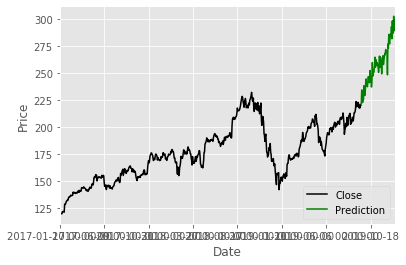

Retrieving AAPL related tweets polarity...


TweepError: Twitter error response: status code = 429

In [20]:
import datetime as dt
import math

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy
from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from textblob import TextBlob


import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx
from textblob import TextBlob
from Tweet import Tweet

style.use('ggplot')

def check_stock_symbol(flag=False, companies_file='companylist.csv'):
    df = pd.read_csv(companies_file, usecols=[0])

    while flag is False:
        symbol = input('Enter a stock symbol to retrieve data from: ').upper()
        for index in range(len(df)):
            if df['Symbol'][index] == symbol:
                flag = True
    return flag, symbol


def get_stock_data(symbol, from_date, to_date):
    data = yf.download(symbol, start=from_date, end=to_date)
    df = pd.DataFrame(data=data)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df['HighLoad'] = (df['High'] - df['Close']) / df['Close'] * 100.0
    df['Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HighLoad', 'Change', 'Volume']]
    return df


def stock_forecasting(df):
    forecast_col = 'Close'
    forecast_out = int(math.ceil(0.1*len(df)))
    df['Label'] = df[[forecast_col]].shift(-forecast_out)

    X = np.array(df.drop(['Label'], axis=1))
    X = preprocessing.scale(X)
    X_forecast = X[-forecast_out:]
    X = X[:-forecast_out]

    df.dropna(inplace=True)
    y = np.array(df['Label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    forecast = clf.predict(X_forecast)

    df['Prediction'] = np.nan

    last_date = df.iloc[-1].name
    last_date = dt.datetime.strptime(str(last_date), "%Y-%m-%d %H:%M:%S")

    for pred in forecast:
        last_date += dt.timedelta(days=1)
        df.loc[last_date.strftime("%Y-%m-%d")] = [np.nan for _ in range(len(df.columns) - 1)] + [pred]
    return df, forecast_out


def forecast_plot(df):
    df['Close'].plot(color='black')
    df['Prediction'].plot(color='green')
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

    
consumer_key = 'susVaehe9d6u0KCDytaB2gtKz'
consumer_secret = 'KXHZocAp6qH3Ko9ucXUJ0HlJt79FCVmJtfiPEB8qbvHqaAXPaE'
access_token = '1214729489730678784-OUXJPAwqsjVgXgsactc8578zbY2oyB'
access_token_secret = 'TuO8TyTR6CAaIBAN8s1j6mLkKpVlHp0S0tAnE775Xwc47'


# def retrieving_tweets_polarity(symbol):
#     auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#     auth.set_access_token(access_token, access_token_secret)
#     user = tweepy.API(auth)

#     tweets = tweepy.Cursor(user.search, q=str(symbol), tweet_mode='extended', lang='en').items(1000)

#     tweet_list = []
#     global_polarity = 0
#     for tweet in tweets:
#         tw = tweet.full_text
#         blob = TextBlob(tw)
#         polarity = 0
#         for sentence in blob.sentences:
#             polarity += sentence.sentiment.polarity
#             global_polarity += sentence.sentiment.polarity
#         tweet_list.append(Tweet(tw, polarity))

#     global_polarity = global_polarity / len(tweet_list)
#     return global_polarity

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# #def tweets():
def retrieving_tweets_polarity(symbol):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    user = tweepy.API(auth)
    
    
    tweets = tweepy.Cursor(user.search,
                   q=str(symbol),
                   lang="en",
                   since="2020-01-07").items(10000)


    tweet_data={}
    for tweet in tweets:
        tweet_date = tweet._json['created_at']
        tweets_no_urls = remove_url(tweet.text)
        tweet_data.update({tweet_date:tweets_no_urls}) #{tweet_date:tweets_no_urls}
    print (tweet_data)


    # Remove URLs
    tweets_no_urls = [remove_url(tweet.text) for tweet in tweets]

    # Store dict keys and values in separate lists
    values=tweet_data.values()
    dates=tweet_data.keys()

    # Create textblob objects of the tweets
    sentiment_objects = [TextBlob(tweet) for tweet in values]
    # sentiment_objects[0].polarity, sentiment_objects[0]

    # Create list of polarity valuesx and tweet text
    sentiment_values = [[str(tweet),dates,ticker,tweet.sentiment.polarity,'Positive' if tweet.sentiment.polarity > 0 else 'Negative' if tweet.sentiment.polarity < 0 else 'Neutral'] for tweet in sentiment_objects]
    # sentiment_values[0]

    # Create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=[ "Tweet","date","Ticker","Score","Polarity"])
    sentiment_df["date"]=dates
    
#     global_polarity = global_polarity / len(tweet_list)
#     return global_polarity
    return sentiment_df['Score']


def recommending(df, forecast_out, global_polarity):
    if df.iloc[-forecast_out-1]['Close'] < df.iloc[-1]['Prediction']:
        if global_polarity > 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a GREAT idea!" % str(symbol))
        elif global_polarity < 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))
    else:
        print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))


if __name__ == "__main__":
    (flag, symbol) = check_stock_symbol(False, 'companylist.csv')
    if flag:
        actual_date = dt.date.today()
        past_date = actual_date - dt.timedelta(days=365 * 3)

        actual_date = actual_date.strftime("%Y-%m-%d")
        past_date = past_date.strftime("%Y-%m-%d")

        print ("Retrieving Stock Data from introduced symbol...")
        dataframe = get_stock_data(symbol, past_date, actual_date)
        print ("Forecasting stock DataFrame...")
        (dataframe, forecast_out) = stock_forecasting(dataframe)
        print ("Plotting existing and forecasted values...")
        forecast_plot(dataframe)
        print ("Retrieving %s related tweets polarity..." % symbol)
        polarity = retrieving_tweets_polarity(symbol)
        print ("Generating recommendation based on prediction & polarity...")
        recommending(dataframe, forecast_out, polarity)


